Demo of the method proposed in *Optimizing Basis Functions in Kernel Ridge Regression (2017)*. 

### Generate some random data

In [1]:
# import os
# os.environ["KERAS_BACKEND"]="tensorflow"
import numpy as np
import keras_okrr
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2034)
N = 5
N_test = 400
lda = 0.001
gamma_inicial = np.float64(.1)
x = np.random.randn(N,1)
y = np.sin(x[:,0]) + .1*np.random.randn(N)

x_test = np.random.uniform(low=-np.pi,high=np.pi,size=(N_test,1))
x_test = np.random.randn(N_test,1)
y_test = np.sin(x_test[:,0])+.1*np.random.randn(N_test)

x_test.shape,y_test.shape,x.shape,y.shape

Using Theano backend.


((400, 1), (400,), (5, 1), (5,))

In [2]:
plt.style.use('seaborn-whitegrid')

def plot_xy(x,y,pred_func,x_test,y_test):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.scatter(x_test,y_test,alpha=.35)
    ax.scatter(x,y,s=80,c="C4",marker="s")
    ax.plot(np.arange(-np.pi,np.pi,.01),pred_func(np.arange(-np.pi,np.pi,.01)),c="C4")
    
    ax.plot(np.arange(-np.pi,np.pi,.01),np.sin(np.arange(-np.pi,np.pi,.01)),c="black")
    return fig,ax


### Apply *standard* KRR using a subset of `N` points

(400, 5)
Err train: 0.0086 Err test: 0.0596


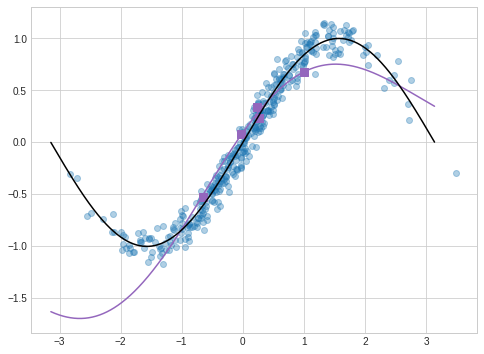

In [3]:
_,alpha,err_train = keras_okrr.krr_numpy(x,y,gamma_inicial,lda)
K_test = keras_okrr.k_test_numpy(x,x_test,gamma_inicial)
print(K_test.shape)

y_hat_test = K_test.dot(alpha)
err_test = np.mean((y_test-y_hat_test)**2)
print("Err train: %.4f Err test: %.4f"%(err_train,err_test))

pred_funct_init = lambda x_t:keras_okrr.k_test_numpy(x,x_t[:,np.newaxis],gamma_inicial).dot(alpha)
fig,ax = plot_xy(x,y,pred_funct_init,x_test,y_test)

### Optimize the centroids using the *optimal alpha* method

Last loss: 0.0108
First loss: 0.0293
Loss without optimization: 0.0596


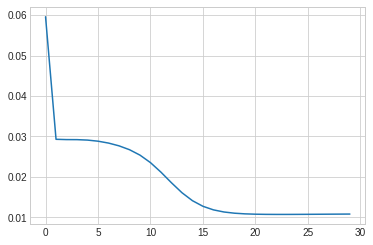

In [4]:
from keras.optimizers import Adam

model_2 = keras_okrr.model_coordinate_descent_alpha(x,y,
                                  init_gamma=gamma_inicial,
                                  lmbda_init=lda,
                                  optimizer=Adam(lr=.1))
nb_epoch = 30
history = model_2.fit(x_test,
                      y_test,
                      batch_size=x_test.shape[0],
                      epochs=nb_epoch,verbose=0)

plt.plot(history.epoch,history.history["loss"])
print("Last loss: %.4f"%history.history["loss"][-1])
print("First loss: %.4f"%history.history["loss"][1])
print("Loss without optimization: %.4f"%history.history["loss"][0])

### Plot solution

Optimized gamma: 0.1000


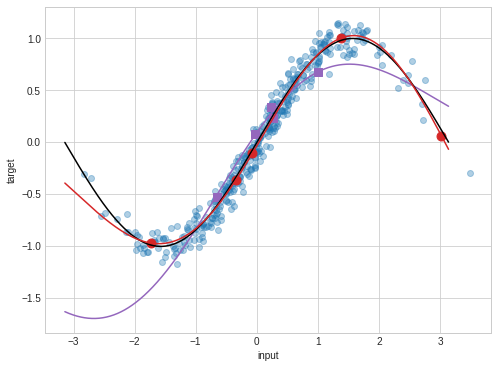

In [5]:
x_opt,gamma_opt = model_2.get_layer("k_test").get_weights()
alpha_opt = model_2.get_layer("alpha").get_weights()
alpha_opt = alpha_opt[0]
K_opt = keras_okrr.k_test_numpy(x_opt,x_opt,gamma_opt)
y_opt = K_opt.dot(alpha_opt)

pred_funct = lambda x_t: model_2.predict(x_t[:,np.newaxis])

fig,ax = plot_xy(x,y,pred_funct_init,x_test,y_test)
ax.scatter(x_opt,y_opt,c="C3",s=80)
ax.plot(np.arange(-np.pi,np.pi,.01),pred_funct(np.arange(-np.pi,np.pi,.01)),c="C3")

ax.set_xlabel("input")
ax.set_ylabel("target")

print("Optimized gamma: %.4f"%gamma_opt)

#import load_data
#import os
#folder = load_data.folder_images_article()
#plt.savefig(os.path.join(folder,"toy_sin.pdf"))

### Optimize the centroids using *mini-batch gradient descent*

Last loss: 0.0127


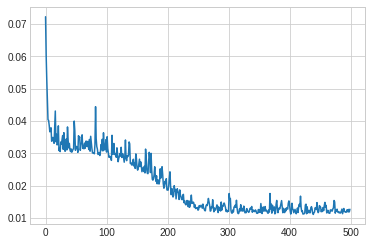

In [6]:
model = keras_okrr.model_all_gd(x,y,init_gamma=gamma_inicial,
                                lmbda_init=lda,
                               optimizer=Adam(lr=.01))

nb_epoch = 500
history = model.fit(x_test,
                    y_test[:,np.newaxis],
                    batch_size=32,
                    epochs=nb_epoch,verbose=0)

plt.plot(history.epoch,history.history["loss"])
print("Last loss: %.4f"%history.history["loss"][-1])

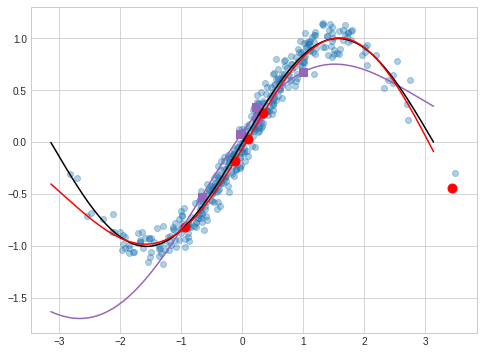

In [7]:
x_opt,gamma_opt = model.get_layer("k_test").get_weights()
alpha_opt = model.get_layer("alpha").get_weights()
alpha_opt = alpha_opt[0]
K_opt = keras_okrr.k_test_numpy(x_opt,x_opt,gamma_opt)
y_opt = K_opt.dot(alpha_opt)

pred_funct = lambda x_t:keras_okrr.k_test_numpy(x,x_t[:,np.newaxis],gamma_inicial).dot(alpha)

fig,ax = plot_xy(x,y,pred_funct,x_test,y_test)

points_x = np.arange(-np.pi,np.pi,.01)
preds =keras_okrr.k_test_numpy(x_opt,
                               points_x[:,np.newaxis],
                               gamma_inicial).dot(alpha_opt)

ax.scatter(x_opt,y_opt,c="red",s=80)
ax.plot(points_x,preds,c="red")



#   Copyright & Disclaimer


The programs contained in this package are granted free of charge for
   research and education purposes only. Scientific results produced using
   the software provided shall acknowledge the use of this implementation
   provided by us. If you plan to use it for non-scientific purposes,
   don't hesitate to contact us. Because the programs are licensed free of
   charge, there is no warranty for the program, to the extent permitted
   by applicable law. except when otherwise stated in writing the
   copyright holders and/or other parties provide the program "as is"
   without warranty of any kind, either expressed or implied, including,
   but not limited to, the implied warranties of merchantability and
   fitness for a particular purpose. the entire risk as to the quality and
   performance of the program is with you. should the program prove
   defective, you assume the cost of all necessary servicing, repair or
   correction. In no event unless required by applicable law or agreed to
   in writing will any copyright holder, or any other party who may modify
   and/or redistribute the program, be liable to you for damages,
   including any general, special, incidental or consequential damages
   arising out of the use or inability to use the program (including but
   not limited to loss of data or data being rendered inaccurate or losses
   sustained by you or third parties or a failure of the program to
   operate with any other programs), even if such holder or other party
   has been advised of the possibility of such damages.

   NOTE: This is just a demo providing a default initialization. Training
   is not at all optimized. Other initializations, optimization techniques,
   and training strategies may be of course better suited to achieve improved
   results in this or other problems.

 Copyright (c) 2017 by Gonzalo Mateo-Garcia
 
 gonzalo.mateo-garcia at **uv** DOT *es*
 
 http://isp.uv.es/
